In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# 6. Decision Analysis

## 6.1 The *Price is Right* problem

On November 1, 2007, contestants named Letia and Nathaniel appeared on
*The Price is Right*, an American game show. They competed
in a game called *The Showcase*, where the objective is to
guess the price of a showcase of prizes. The contestant who comes
closest to the actual price of the showcase, without going over, wins
the prizes.

Nathaniel went first. His showcase included a dishwasher, a wine
cabinet, a laptop computer, and a car. He bid \$26,000.

Letia’s showcase included a pinball machine, a video arcade game, a pool
table, and a cruise of the Bahamas. She bid \$21,500.

The actual price of Nathaniel’s showcase was \$25,347. His bid was too
high, so he lost.

The actual price of Letia’s showcase was \$21,578. She was only off by
\$78, so she won her showcase and, because her bid was off by less than
\$250, she also won Nathaniel’s showcase.

For a Bayesian thinker, this scenario suggests several questions:

1.  Before seeing the prizes, what prior beliefs should the contestant
    have about the price of the showcase?

2.  After seeing the prizes, how should the contestant update those
    beliefs?

3.  Based on the posterior distribution, what should the contestant bid?

The third question demonstrates a common use of Bayesian analysis:
decision analysis. Given a posterior distribution, we can choose the bid
that maximizes the contestant’s expected return.

This problem is inspired by an example in Cameron Davidson-Pilon’s book,
*Bayesian Methods for Hackers*. The data needed for this chapter are stored in the folder data in showcases2011.csv and showcases2012.csv.

## 6.2 The prior

To choose a prior distribution of prices, we can take advantage of data
from previous episodes. Fortunately, fans of the show keep detailed
records. When I corresponded with Mr. Davidson-Pilon about his book, he
sent me data collected by Steve Gee at <http://tpirsummaries.8m.com>. It
includes the price of each showcase from the 2011 and 2012 seasons and
the bids offered by the contestants.

First, lets define an auxiliary function to read-in and prepare the data:

In [2]:
def read_data_06():
    ''' Function to read-in and prepare data for this chapter'''
    import pandas as pd
    
    get_df = lambda pth: pd.read_table(pth,sep=',',index_col=0, header= [0,1], keep_default_na=True).T.dropna(how='all',axis=1)

    pth1=r"../data/showcases2011.csv"
    pth2=r"../data/showcases2012.csv"

    df=pd.concat([get_df(pth1),get_df(pth2)])
    return df

df=read_data_06()

Figure 6.1 shows the distribution of prices for these
showcases. The most common value for both showcases is around \$28,000,
but the first showcase has a second mode near \$50,000, and the second
showcase is occasionally worth more than \$70,000.

These distributions are based on actual data, but they have been
smoothed by Gaussian kernel density estimation (KDE). Before we go on, I
want to take a detour to talk about probability density functions and
KDE.

In [3]:
#function to get a KDE on aset of data 
def get_kde(all_values,est_values):
    kernel = stats.gaussian_kde(all_values)
    pdf = kernel.evaluate(est_values)
    pmf = kernel.evaluate(est_values)/pdf.sum()
    return pmf

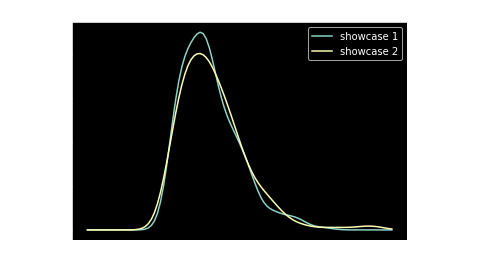

In [4]:
#code for Figure 6.1
price_xk=np.linspace(0,75000,101)

price1_pmf=get_kde(df['Showcase 1'],price_xk)
price2_pmf=get_kde(df['Showcase 2'],price_xk)

plt.plot(price_xk,price1_pmf,label='showcase 1')
plt.plot(price_xk,price2_pmf,label='showcase 2')
plt.xlabel('Price ($)');
plt.ylabel('PDF');
plt.legend()
plt.title('Figure 6.1 Distribution of prices for showcases on The Price is Right, 2011-12');

## 6.3 Probability density functions

So far we have been working with probability mass functions, or PMFs. A
PMF is a map from each possible value to its probability. In my
implementation, a Pmf object provides a method named Prob
that takes a value and returns a probability, also known as a
**probability mass**.

A **probability density function**, or PDF, is the
continuous version of a PMF, where the possible values make up a
continuous range rather than a discrete set.

In mathematical notation, PDFs are usually written as functions; for
example, here is the PDF of a Gaussian distribution with mean 0 and
standard deviation 1: 

$$f(x) = \frac{1}{\sqrt{2 \pi}} \exp(-x^2/2)$$

For a given value of $x$, this function computes a probability density. A
density is similar to a probability mass in the sense that a higher
density indicates that a value is more likely.

But a density is not a probability. A density can be 0 or any positive
value; it is not bounded, like a probability, between 0 and 1.

If you integrate a density over a continuous range, the result is a
probability. But for the applications in this book we seldom have to do
that.

Instead we primarily use probability densities as part of a likelihood
function. We will see an example soon.

## 6.4 Representing PDFs

To define continuous distributions distribution objects from `scipy.stats` module are used in the following. Each distribution object has `pdf` method to evaluate the distribution's PDF at given points. To reduce a PDF to a corresponding PMF for a set of values $x$, PDF values of the continuous distribution have to be calculated for all $x$ and then normalized so that the sum of PMF values equals to 1.

probability density of norm at the value of 1 is 3.99


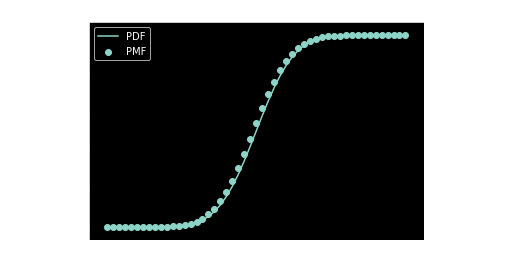

In [5]:
norm = stats.norm(loc=1,scale=0.1)
print(f"probability density of norm at the value of 1 is {norm.pdf(1):1.2f}")

x=np.linspace(0.5,1.5,51, endpoint=True)
norm_pmf = norm.pdf(x)
norm_pmf = norm_pmf/ norm_pmf.sum()

plt.plot(x,norm.cdf(x),label='PDF')
plt.scatter(x,norm_pmf.cumsum()   ,label='PMF')
plt.xlabel('x');
plt.ylabel('Probability');
plt.legend()
plt.title('Figure (not in the original) CDF of a continuous and discretized normal distribution');

The Gaussian distribution is also called the “normal”
distribution. This name is used in `scipy.stats` module. 

The Gaussian PDF is defined by a simple mathematical function, so it is
easy to evaluate. And it is useful because many quantities in the real
world have distributions that are approximately Gaussian.

But with real data, there is no guarantee that the distribution is
Gaussian or any other simple mathematical function. In that case we can
use a sample to estimate the PDF of the whole population.

For example, in *The Price Is Right* data, we have 313
prices for the first showcase. We can think of these values as a sample
from the population of all possible showcase prices.

This sample includes the following values (in order):

$$28800, 28868, 28941, 28957, 28958$$ 

In the sample, no values appear
between 28801 and 28867, but there is no reason to think that these
values are impossible. Based on our background information, we expect
all values in this range to be equally likely. In other words, we expect
the PDF to be fairly smooth.

Kernel density estimation (KDE) is an algorithm that takes a sample and
finds an appropriately smooth PDF that fits the data. You can read
details at <http://en.wikipedia.org/wiki/Kernel_density_estimation>.

`scipy` provides an implementation of KDE that has already been used
in `get_kde` function above. KDE is continuos, so it can be evaluated 
for any point. To discretize it, the same procedure as for normal distribution 
above should be used. KDE is be evaluated at the points of interest and then the 
resulting values are normalized.

And now back to *The Price is Right*.

## 6.5 Modeling the contestants

The PDFs in Figure 6.1 estimate the distribution of possible
prices. If you were a contestant on the show, you could use this
distribution to quantify your prior belief about the price of each
showcase (before you see the prizes).

To update these priors, we have to answer these questions:

1.  What data should we consider and how should we quantify it?

2.  Can we compute a likelihood function; that is, for each hypothetical
    value of `price`, can we compute the conditional
    likelihood of the data?

To answer these questions, I am going to model the contestant as a
price-guessing instrument with known error characteristics. In other
words, when the contestant sees the prizes, he or she guesses the price
of each prize—ideally without taking into consideration the fact that
the prize is part of a showcase—and adds up the prices. Let’s call this
total `guess`.

Under this model, the question we have to answer is, “If the actual
price is `price`, what is the likelihood that the
contestant’s estimate would be `guess`?”

Or if we define

$$error = price - guess$$

then we could ask, “What is the likelihood that the contestant’s
estimate is off by `error`?”

To answer this question, we can use the historical data again.
Figure 6.2 shows the cumulative distribution of
`diff`, the difference between the contestant’s bid and the
actual price of the showcase.

The definition of diff is

$$diff = price - bid$$

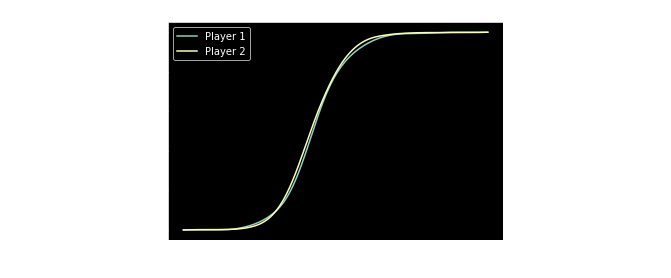

In [6]:
left  = df.loc[:,['Difference 1', 'Difference 2']].min().min()
right = df.loc[:,['Difference 1', 'Difference 2']].max().max()
difference_xk = np.linspace(left,right,1000)

difference1_cdf=get_kde(df['Difference 1'],difference_xk).cumsum()
difference2_cdf=get_kde(df['Difference 2'],difference_xk).cumsum()

plt.plot(difference_xk,difference1_cdf,label='Player 1')
plt.plot(difference_xk,difference2_cdf,label='Player 2')
plt.xlabel('diff ($)');
plt.ylabel('CDF');
plt.legend()
plt.title('Figure 6.2: Cumulative distribution (CDF) of the difference between the contestant’s bid and the actual price');

When `diff` is negative, the bid is too high. As an aside, we
can use this distribution to compute the probability that the
contestants overbid: the first contestant overbids 25% of the time; the
second contestant overbids 29% of the time.

In [7]:
idx0 = np.fabs(difference_xk).argmin()
print(f"Probability of overbidding: Player 1 {difference1_cdf[idx0]:1.2f} and Player 2 {difference2_cdf[idx0]:1.2f}")

Probability of overbidding: Player 1 0.27 and Player 2 0.30


NOTE: Slightly different numbers than in the book. Possible reason is a larger number of `difference_xk` values.

We can also see that the bids are biased; that is, they are more likely
to be too low than too high. And that makes sense, given the rules of
the game.

Finally, we can use this distribution to estimate the reliability of the
contestants’ guesses. This step is a little tricky because we don’t
actually know the contestant’s guesses; we only know what they bid.

So we’ll have to make some assumptions. Specifically, I assume that the
distribution of `error` is Gaussian with mean 0 and the same
variance as `diff`.

In [8]:
error1_dist=stats.norm(loc=0,scale=df['Difference 1'].std(ddof=1))
error2_dist=stats.norm(loc=0,scale=df['Difference 2'].std(ddof=1))

NOTE: Deafult number of degrees of freedom `ddof` to calculate standard deviation in pandas is `dd0f=1` in numpy, however, the default value it is `ddof=0`. As far as a sample is considered `ddof=1` should be used.

`df['Difference 1']` and `df['Difference 2']` are differences between
the prices and the bids made by Player 1 and 2, respectively $diff = price - bid$.

`error1_dist` and `error2_dist` are distributions characterizing  
distributions of errors for Player 1 and 2, where $error = price - guess$.

Again, we use the variance of $diff$ to estimate the variance
of $error$. This estimate is not perfect because contestants’
bids are sometimes strategic; for example, if Player 2 thinks that
Player 1 has overbid, Player 2 might make a very low bid. In that case
$diff$ does not reflect $error$. If this happens a
lot, the observed variance in $diff$ might overestimate the
variance in $error$. Nevertheless, I think it is a reasonable
modeling decision.

As an alternative, someone preparing to appear on the show could
estimate their own distribution of $error$ by watching
previous shows and recording their guesses and the actual prices.

## 6.6 Likelihood

Now we are ready to define the likelihood function. In this case,
hypothesis is the hypothetical price of the showcase. Data is 
the contestant’s best guess at the price. Error (`error`) is 
is the difference between the price and the best guess. Finally, likelihood is the
likelihood of the data (best guess), given the hypothesis (price).

In [9]:
error=20000
likelihood1=error1_dist.pdf(error)
likelihood2=error2_dist.pdf(error)

`likelihood`  is obtained by calling the `pdf` method of
an error distribution evaluating at the given
value of `error`. The result is a probability density, so it
is not really a probability. But remember that `likelihood`
doesn’t need to compute a probability; it only has to compute something
*proportional* to a probability. As long as the constant of
proportionality is the same for all likelihoods, it gets canceled out
when we normalize the posterior distribution.

And therefore, a probability density is a perfectly good likelihood.

## 6.7 Update

Function `get_posterior` takes the prices (hypotheses), contestant’s best guess (data),
contestant’s error distribution (likelihood), PMF of prices (prior) and computes 
the posterior distribution.

In [10]:
def get_posterior(price_xk,best_guess,error_dist,pmf_price):
    errors = price_xk-best_guess
    likelihood=error_dist.pdf(errors)
    
    _product = likelihood*pmf_price
    posterior_price = _product / _product.sum()
    return posterior_price

`price` are the considered points in the distribution of price. `best_guess` is a contestants's best guess, `error_dist` is the error distribution. `price_pmf` is a discrete approximation to the PDF of price (which we use to construct the prior), and `X` is the contestants number.

To construct the posterior, we calculate errors, determine the likelihood for all errors, multiply likelihood with each prior and normalize the outcome.

So let’s get back to the original scenario. Suppose you are Player 1 and
when you see your showcase, your best guess is that the total price of
the prizes is \$20,000.

In [22]:
best_guess1=20000
price1_posterior_pmf=get_posterior(price_xk,best_guess1,error1_dist,price1_pmf)

best_guess2=40000
price2_posterior_pmf=get_posterior(price_xk,best_guess2,error2_dist,price2_pmf)

Figure 6.3 shows prior and posterior beliefs about the actual
price. The posterior is shifted to the left because your guess is on the
low end of the prior range.

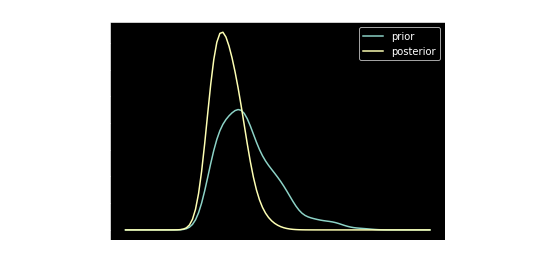

In [23]:
plt.plot(price_xk,price1_pmf,          label='prior')
plt.plot(price_xk,price1_posterior_pmf,label='posterior')
plt.xlabel('price ($)');
plt.ylabel('PMF');
plt.legend()
plt.title('Figure 6.3: Prior and posterior distributions for Player 1, based on a best guess of \$20000');

On one level, this result makes sense. The most likely value in the
prior is \$27,750, your best guess is \$20,000, and the mean of the
posterior is somewhere in between: \$25,096.

On another level, you might find this result bizarre, because it
suggests that if you *think* the price is \$20,000, then
you should *believe* the price is \$24,000.

To resolve this apparent paradox, remember that you are combining two
sources of information, historical data about past showcases and guesses
about the prizes you see.

We are treating the historical data as the prior and updating it based
on your guesses, but we could equivalently use your guess as a prior and
update it based on historical data.

If you think of it that way, maybe it is less surprising that the most
likely value in the posterior is not your original guess.

## 6.8 Optimal bidding

Now that we have a posterior distribution, we can use it to compute the
optimal bid, which I define as the bid that maximizes expected return
(see <http://en.wikipedia.org/wiki/Expected_return>).

I’m going to present two implementations. The first one, is a direct
approach using a `for` loop. The second one, is a vectorized 
implementation leveraging `numpy` arrays. The code is given first and
then it is followed by some explanations.

In [24]:
def get_closest_idxs(array, values):
    #based on https://stackoverflow.com/a/46184652/4395722
    
    # get insert positions
    idxs = np.searchsorted(array, values, side="left")

    # find indexes where previous index is closer
    prev_idx_is_less = ((idxs == len(array)) |
                                             (np.fabs(values - array[np.maximum(idxs-1, 0)]) < 
                                              np.fabs(values - array[np.minimum(idxs, len(array)-1)])
                                             )
                       )
    idxs[prev_idx_is_less] -= 1

    return idxs

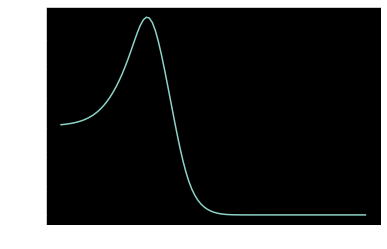

In [31]:
guess1=20000

bids=np.linspace(0,75000,101)

expected_gains=[]
_diff=[]

for bid in bids:    
    total=0
    for price, post_prob in zip(price_xk, price1_posterior_pmf):
        diff = price - bid
        _diff.append(diff)
        if diff<0:
            gain=0
        else:          
            idxs_cdf_diff = get_closest_idxs(difference_xk, np.array([diff]))
            idx_cdf_neg   = get_closest_idxs(difference_xk, np.array([-1  ]))
        
            prob_worse   = 1 - difference2_cdf[idxs_cdf_diff]
            prob_overbid =     difference2_cdf[idx_cdf_neg]
        
            prob = prob_worse + prob_overbid
        
            gain = prob * price
        
            if diff <= 250:
                gain *= 2
            
        total += gain * post_prob
        
    expected_gains.append(total)

In [ ]:
#Figure not in the original book
plt.plot(bids,expected_gains, label='Player 1');
plt.xlabel('bid ($)');
plt.ylabel('expected gain (\$)');
plt.legend()
plt.title('Figure X: Expected gain versus bid in a scenario where Player 1’s best guess is \$20,000');

In [38]:
#guess1=20000
#guess2=40000

bids=np.linspace(0,75000,101)

mg_bids, mg_price_xk = np.meshgrid(bids, price_xk)
mg_diff  = mg_price_xk - mg_bids

mg_probs1 = np.zeros_like(mg_diff)
mg_probs2 = np.zeros_like(mg_diff)

idx_positive_diff = mg_diff>=0
idxs_cdf_diff=get_closest_idxs(difference_xk, mg_diff[idx_positive_diff])
idx_cdf_neg = get_closest_idxs(difference_xk, np.array([-1]))

#Player 1
prob_worse1 = 1 - difference2_cdf[idxs_cdf_diff]
prob_overbid1 = difference2_cdf[idx_cdf_neg]
mg_probs1[idx_positive_diff] = prob_worse1 + prob_overbid1
mg_gains1 = mg_hypos_price * mg_probs1
mg_gains1[mg_diff<250] *= 2
mg_gains1 = mg_gains1*price1_posterior_pmf[:,None]
expected_gains1 = mg_gains1.sum(axis=0)

#Player 2
prob_worse2 = 1 - difference1_cdf[idxs_cdf_diff]
prob_overbid2 = difference1_cdf[idx_cdf_neg]
mg_probs2[idx_positive_diff] = prob_worse2 + prob_overbid2
mg_gains2 = mg_hypos_price * mg_probs2
mg_gains2[mg_diff<250] *= 2 
mg_gains2 = mg_gains2*price2_posterior_pmf[:,None]
expected_gains2 = mg_gains2.sum(axis=0)

Figure Figure 6.4 shows the results for both players, based on a
scenario where Player 1’s best guess is \$20,000 and Player 2’s best
guess is \$40,000.

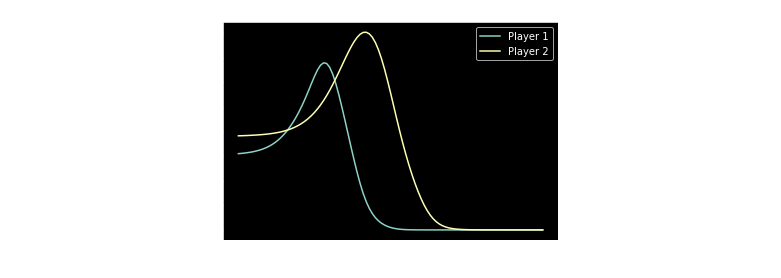

In [39]:
#Figure 6.4
plt.plot(bids,expected_gains1, label = 'Player 1')
plt.plot(bids,expected_gains2, label = 'Player 2')
plt.xlabel('bid ($)');
plt.ylabel('expected gain (\$)');
plt.legend()
plt.title('Figure 6.4: Expected gain versus bid in a scenario where Player 1’s best guess is \$20,000 and Player 2’s best guess is \$40,000');

In [40]:
gb1 = max(zip(expected_gains1,bids))
gb2 = max(zip(expected_gains2,bids))
print(f'Player 1: expected return {gb1[0]:0.0f}; optimal bid: {gb1[1]:0.0f}')
print(f'Player 2: expected return {gb2[0]:0.0f}; optimal bid: {gb2[1]:0.0f}')

Player 1: expected return 16969; optimal bid: 21000
Player 2: expected return 20073; optimal bid: 31500


For Player 1 the optimal bid is \$21,000, yielding an expected return of
almost \$16,700. This is a case (which turns out to be unusual) where
the optimal bid is actually higher than the contestant’s best guess.

For Player 2 the optimal bid is \$31,500, yielding an expected return of
almost \$19,400. This is the more typical case where the optimal bid is
less than the best guess.

NOTE. The calculated expected gains deviate slightly from the values in the original book (Player 1 16700 and Player 2 19400). 

## Discussion

One of the features of Bayesian estimation is that the result comes in
the form of a posterior distribution. Classical estimation usually
generates a single point estimate or a confidence interval, which is
sufficient if estimation is the last step in the process, but if you
want to use an estimate as an input to a subsequent analysis, point
estimates and intervals are often not much help.

In this example, we use the posterior distribution to compute an optimal
bid. The return on a given bid is asymmetric and discontinuous (if you
overbid, you lose), so it would be hard to solve this problem
analytically. But it is relatively simple to do computationally.

Newcomers to Bayesian thinking are often tempted to summarize the
posterior distribution by computing the mean or the maximum likelihood
estimate. These summaries can be useful, but if that’s all you need,
then you probably don’t need Bayesian methods in the first place.

Bayesian methods are most useful when you can carry the posterior
distribution into the next step of the analysis to perform some kind of
decision analysis, as we did in this chapter, or some kind of
prediction, as we see in the next chapter.